# Masked reconstruction with Eva

This notebook contains how to use Eva to predict masked tokens and cross-modality prediction (Figure 2).

In [ ]:
# change work dir
import os

os.chdir("/Your/path/to/Eva")

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf

from Eva.utils import create_model, extract_features, load_from_hf
from utils.helpers import patchify, unpatchify, masking, rearrange

In [31]:
conf = OmegaConf.load("config.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"
patch_size = 8
image_size = 224

model = load_from_hf(
    repo_id="yandrewl/Eva",
    conf=conf,
    device=device
)

Checkpoint downloaded to: /home/yfliu/.cache/huggingface/hub/models--yandrewl--Eva/snapshots/5dac7105ba22c347a1f76e931576123e08fe50f7/Eva_model.ckpt
Model loaded successfully from HuggingFace Hub


In [ ]:
# Load examples of H&E and MIF patches with size of 224*224
mif_patch_np = np.load("examples/masked_prediction/MIF_patch.npy")
he_patch_np = np.load("examples/masked_prediction/HE_patch.npy") / 255.0
biomarkers = np.load("examples/masked_prediction/biomarkers.npy", allow_pickle=True).tolist()

print(biomarkers)
channel_selected = [biomarkers.index(i) for i in ['DAPI', 'CD45', 'aSMA']]

['CD20', 'Podoplanin', 'Gal3', 'ERa', 'MPO', 'CD31', 'CD21', 'CD40', 'VISTA', 'FoxP3', 'Ki67', 'TP63', 'HLA-DR', 'GranzymeB', 'CD141', 'CD38', 'TIGIT', 'CD11c', 'CollagenIV', 'BCL2', 'CD8', 'CD14', 'DAPI', 'CD4', 'aSMA', 'Keratin8/18', 'EpCAM', 'CD45RO', 'Caveolin1', 'PCNA', 'PD1', 'ICOS', 'PanCK', 'CD45', 'CD39', 'PDL1', 'GATA3', 'CD163', 'ATM', 'Vimentin', 'IDO1', 'CD34', 'LAG3', 'CD44', 'ECad', 'CD68', 'CD66', 'IFNg', 'HLA-E', 'CD3e', 'CD79', 'HLA-ABC']


In [33]:
# generate a masked image to show input image
def generate_masking_input(input_data, infer_mask, set_reverse=False):
    input_patches = patchify(input_data.to(torch.float32), patch_size=patch_size)
    B, H, W, P1, P2, C = input_patches.shape
    input_patches = rearrange(input_patches, "B H W P1 P2 C -> B C (H W) (P1 P2)")  # [B, C, N, D]
    masked_input = input_patches.to(device) * (1 - infer_mask[None, ..., None]).repeat(1, 1, 1, P1 * P2).to(device)  # masked input patches
    if set_reverse:  # reverse the masked color as white
        masked_input += infer_mask[None, ..., None].repeat(1, 1, 1, P1 * P2).to(device)  # set masked areas to 1 (white)
    masked_input = rearrange(masked_input, "B C (H W) (P1 P2) -> B H W P1 P2 C", B=B, H=H, W=W, P1=P1, P2=P2, C=C)
    masked_input = unpatchify(masked_input)
    return masked_input[0].detach().cpu().numpy()

# recontruct by Eva
def generate_recon_images(input_data, mask_strategy, masking_ratio, marker_in, makrer_out=None, channel_specified=None):
    masker = masking(masking_ratio, mask_strategy)

    if channel_specified is not None:
        assert mask_strategy == 'specified'
        infer_mask = masker(torch.randn(16, input_data.shape[-1], 
                                        (image_size // patch_size) ** 2, 2), channel_specified).to(device)
    else:
        infer_mask = masker(
            torch.randn(16, input_data.shape[-1], (image_size // patch_size) ** 2, 2),
        ).to(device)

    # generate a patch mask for infer, with shape [B, C, N, D], actually B and D does not matter :)
    image_in = input_data.to(torch.float32)
    if len(image_in.shape) == 3:
        image_in = image_in.unsqueeze(0)
    image_in = image_in.to(device)

    with torch.no_grad():
        image_recon, _, _ = model(
            image_in,
            marker_in=[marker_in],
            marker_out=makrer_out,
            infer_mask=infer_mask,
            channel_mask=None,
        )
    return image_recon[0].detach().cpu().numpy(), infer_mask

## Masked reconstruction under different masking strategies

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013580561..1.0323064].


Text(0.5, 1.0, 'Reconstructed')

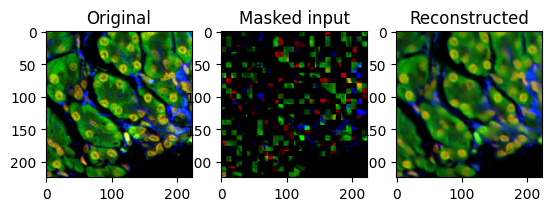

In [34]:
# 1. random masking
mif_patch = torch.from_numpy(mif_patch_np).unsqueeze(0)[..., channel_selected]
image_recon, infer_mask = generate_recon_images(mif_patch, "random", 0.75, ['DAPI', 'CD45', 'aSMA'])
masked_input = generate_masking_input(mif_patch, infer_mask)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(mif_patch_np[..., channel_selected].astype(np.float32))
ax[1].imshow(masked_input)
ax[2].imshow(image_recon)

ax[0].set_title("Original")
ax[1].set_title("Masked input")
ax[2].set_title("Reconstructed")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041906748..1.0799083].


Text(0.5, 1.0, 'Reconstructed')

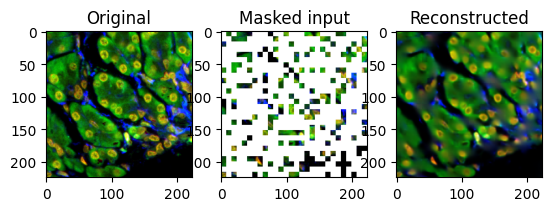

In [35]:
# 2. patch masking
image_recon, infer_mask = generate_recon_images(mif_patch, "patch", 0.75, marker_in=['DAPI', 'CD45', 'Vimentin'])
masked_input = generate_masking_input(mif_patch, infer_mask, set_reverse=True)  # for better visualization, here set masked patches as 

fig, ax = plt.subplots(1, 3)
ax[0].imshow(mif_patch_np[..., channel_selected].astype(np.float32))
ax[1].imshow(masked_input)
ax[2].imshow(image_recon)

ax[0].set_title("Original")
ax[1].set_title("Masked input")
ax[2].set_title("Reconstructed")

Text(0.5, 1.0, 'Predicted')

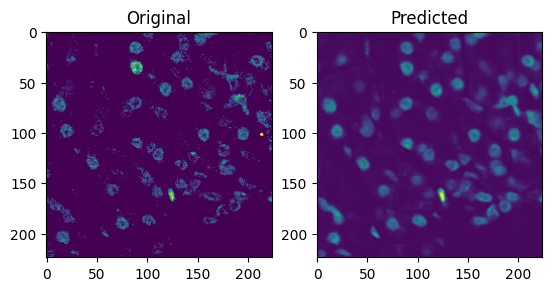

In [ ]:
# 3. channel masking
mif_patch = torch.from_numpy(mif_patch_np).unsqueeze(0)
# here we use other channels to predict the first channel, i.e. CD20
image_recon, infer_mask = generate_recon_images(mif_patch, "specified", 0.75, marker_in=biomarkers, channel_specified=[0])  
masked_input = generate_masking_input(mif_patch, infer_mask)  

fig, ax = plt.subplots(1, 2)
ax[0].imshow(mif_patch_np[..., 0].astype(np.float32))
ax[1].imshow(image_recon[..., 0]) 

ax[0].set_title("Original")
ax[1].set_title("Predicted")

Text(0.5, 1.0, 'Predicted')

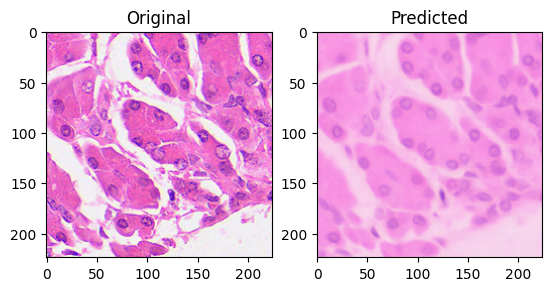

In [ ]:
# 4. Image translation (MIF -> H&E)
mif_patch = torch.from_numpy(mif_patch_np).unsqueeze(0)
with torch.no_grad():
    image_recon, _, _ = model(
        mif_patch.to(torch.float32).to(device),
        marker_in=[biomarkers],
        marker_out=[['HECHA1', 'HECHA2', 'HECHA3']],
        infer_mask=None,
        channel_mask=None,
    )
fig, ax = plt.subplots(1, 2)
ax[0].imshow(he_patch_np.astype(np.float32))
ax[1].imshow(1 - image_recon.detach().cpu().numpy()[0])  # H&E color was reversed during training

ax[0].set_title("Original")
ax[1].set_title("Predicted")

In [ ]:
# 5. Image translation (H&E -> MIF)
# This translation is based on a fine-tuned weights, coming soon!